In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_csv("https://github.com/garyongguanjie/moviecsv/raw/master/movie_cleaned.csv") #cleaning of data is taken out as it takes too long
df = df.drop_duplicates(subset='movie_title', keep="first")
# df['rating'] = df['rating'].apply(lambda x:"safe" if(x=="PG13"or x=="PG") else "unsafe")
def ordinalise(rating):
  ordinal_dict = {'PG':0,'PG13':1,'NC16':2,'M18':3,'R21':4}
  return ordinal_dict[rating]
df['ordinal_rating'] =  df['rating'].apply(lambda x:ordinalise(x))
df.head()

,movie_title,synopsis,rating,synopsis_clean,ordinal_rating
0,Watchmen,"""Watchmen"" is set in an alternate 1985 America...",R21,watchman set alternate america costumed superh...,4
1,Dolemite Is My Name,"In 1970s Los Angeles, Rudy Ray Moore (Eddie Mu...",R21,los angeles rudy ray moore eddie murphy strugg...,4
2,Midsommar,"The film opens with a mural of a bizarre, eeri...",R21,film open mural bizarre eerie ritual taking pl...,4
3,American History X,"In the opening scene, we see waves crashing ov...",R21,opening scene see wave crashing beach eventual...,4
4,Call Me by Your Name,"In the summer of 1983, somewhere in northern I...",R21,summer somewhere northern italy seventeen year...,4


In [0]:
g = df.groupby('rating')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df = g.droplevel(0)
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
print(len(df))

2040


In [0]:
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
df.shape

(5057, 4)

In [0]:
df['synopsis'].apply(lambda x: len(x.split(' '))).sum()

2408795

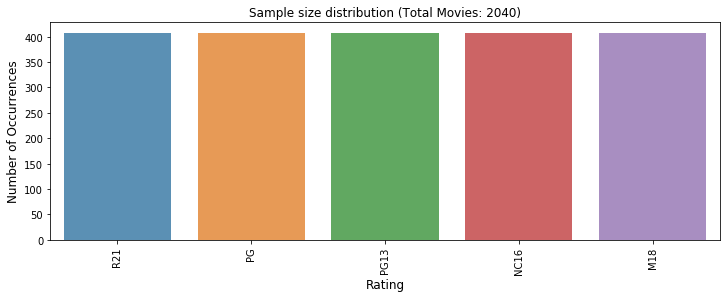

In [5]:
cnt_rate = df['rating'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_rate.index, cnt_rate.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.xticks(rotation=90)
plt.title('Sample size distribution (Total Movies: %s)' %str(len(df)))
plt.show();

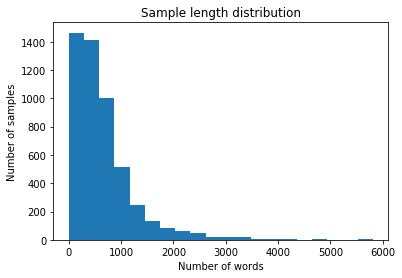

In [0]:
plt.hist(df['synopsis_clean'].str.split().apply(len),bins =20);
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [6]:
print(df['synopsis'][0])

Cheng Cong, the matriarch of a wealthy Shanghainese family in Hong Kong, is financing the production of a new play in Hong Kong's venerable City Hall. The play is Two Sisters, a retro melodrama in the vein of Tennessee Williams, written and directed by the trans woman Ouyang An. As the two sisters of the title, the production will star Yuan Xiuling (a stage veteran making a comeback five years after retiring from the theatre, and one year after the death of her faithless husband Cheng Jun - who was Cheng Cong's younger brother) and He Yuwen (a smart movie actress making her stage debut, who happens to have nursed a career-long rivalry with her co-star). The production is scheduled to have its first night in one week's time.
The run-up to the first night is eventful. Yuan Xiuling has been left financially embarrassed by her late husband's apparent failure to provide for her, and worries where she will live and how she will pay for her son Yuan's boarding-school fees in England. She has 

In [0]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['synopsis'] = df['synopsis'].apply(cleanText)

In [9]:
print(df['synopsis'][0])

cheng cong, the matriarch of a wealthy shanghainese family in hong kong, is financing the production of a new play in hong kong's venerable city hall. the play is two sisters, a retro melodrama in the vein of tennessee williams, written and directed by the trans woman ouyang an. as the two sisters of the title, the production will star yuan iuling (a stage veteran making a comeback five years after retiring from the theatre, and one year after the death of her faithless husband cheng jun - who was cheng cong's younger brother) and he yuwen (a smart movie actress making her stage debut, who happens to have nursed a career-long rivalry with her co-star). the production is scheduled to have its first night in one week's time.
the run-up to the first night is eventful. yuan iuling has been left financially embarrassed by her late husband's apparent failure to provide for her, and worries where she will live and how she will pay for her son yuan's boarding-school fees in england. she has am

In [51]:
# train, test = train_test_split(df, test_size=0.3, random_state=42)

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['synopsis']), tags=[r.ordinal_rating]), axis=1)
# test_tagged = df.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['synopsis']), tags=[r.ordinal_rating]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
import multiprocessing
cores = multiprocessing.cpu_count()
model_dbow =Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

In [0]:
for epoch in range(50):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=10)) for doc in sents])
    return targets, regressors

In [0]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
# y_test, X_test = vec_for_learning(model_dbow, test_tagged)


In [0]:
# print(X_train)

In [0]:
logreg = LogisticRegression(C=1e4)
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
# from sklearn.metrics import accuracy_score, f1_score
# print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
# print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [62]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(logreg,X_train,y_train,cv=10,scoring='neg_mean_squared_error')))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

-4.06590243902439


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

acc_scores = []
score_arr = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cv.split(df):
  # print(train_index, test_index)
  train = df.iloc[train_index]
  test = df.iloc[test_index]
  # print(len(train),len(test))
  # print(train.head())
  # print(test.head())
  train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['synopsis']), tags=[r.rating]), axis=1)
  test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['synopsis']), tags=[r.rating]), axis=1)
  model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
  model_dbow.build_vocab([x for x in train_tagged.values])
  for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.001
    model_dbow.min_alpha = model_dbow.alpha
  y_train, X_train = vec_for_learning(model_dbow, train_tagged)
  y_test, X_test = vec_for_learning(model_dbow, test_tagged)
  logreg = LogisticRegression(C=1e4)
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print(accuracy_score(y_test, y_pred))
  acc_scores.append(accuracy_score(y_test, y_pred))
  score_arr.append(precision_recall_fscore_support(y_test, y_pred, average=None))

avg_acc = np.mean(acc_scores)
print('accuracy is {}'.format(avg_acc))
avg_score = np.mean(score_arr, axis=0)
print(avg_score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3382352941176471


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3284313725490196


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3480392156862745


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3431372549019608


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3137254901960784


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3872549019607843


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3382352941176471


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3627450980392157


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.27941176470588236


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3235294117647059
accuracy is 0.3362745098039216
[[ 0.25945217  0.31770493  0.43880461  0.31923067  0.36850323]
 [ 0.28055158  0.29565842  0.39432016  0.33073414  0.38992885]
 [ 0.26689201  0.30347161  0.41342904  0.32386587  0.3739441 ]
 [40.8        40.8        40.8        40.8        40.8       ]]


In [0]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['synopsis']), tags=[r.rating]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['synopsis']), tags=[r.rating]), axis=1)
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.001
    model_dbow.min_alpha = model_dbow.alpha
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(C=1e4)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.35130718954248363
Testing F1 score: 0.3497868242001777


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
def show_confusion_matrix(conf_mat,classifier):
  import seaborn as sn
  labels = classifier.classes_
  df_cm = pd.DataFrame(conf_mat, index = [i for i in labels ],
                  columns = [i for i in labels])
  plt.figure(figsize = (10,7))
  plt.ylim((-2,2))
  s= sn.heatmap(df_cm, annot=True,fmt="d")
  s.set(xlabel="predicted",ylabel="actual")
  plt.show()
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         M18       0.20      0.19      0.20       113
        NC16       0.25      0.24      0.25       123
          PG       0.49      0.50      0.49       125
        PG13       0.37      0.35      0.36       124
         R21       0.42      0.46      0.44       127

    accuracy                           0.35       612
   macro avg       0.35      0.35      0.35       612
weighted avg       0.35      0.35      0.35       612

